# Terminating a Relationship: Continuous State

#### Jaap Abbring, 22 May 2018

This notebook studies a *continuous-state version* of the stationary optimal stopping problem in `terminingRelationship.ipynb` (with a slightly different default specification to make the comparison more interesting). In `terminingRelationship.ipynb`, we have already seen that discretization of this problem is feasible. This notebook revisits this discretized problem for comparison with the approximate solution of the original, continuous problem.

## The Decision Problem

Suppose again that you are in a relationship. At time $t$, this relationship returns a flow of utility $u(X_t)$ to you, with $u$ nondecreasing. Here, $X_t$ is a driver of relational satisfaction, which follows a normal random walk with drift $\mu$ and innovation variance $\sigma^2$ (note that, originally, we took $X_t$ to *mimic* such a process on a *finite* grid of support points). In each period $t$ the relationship is still alive, after observing $X_t$, you either decide to terminate the relationship and collect an outside utility of $0$, or choose to continue the relationship, collect $u(X_t)$ now and expected future utility discounted with factor $0\leq\rho<1$. What is your optimal decision rule and how does it depend on your love for the future, $\rho$, and the uncertainty you are facing, $\sigma$?

## Recall the Discretized Problem
### A Discretized Random Walk with Drift

We first construct a Markov transition matrix `capPi` ($\Pi$) that mimics a normal random walk with drift `mu` ($\mu$) and standard deviation `sigma` ($\sigma$) on a grid of `nSuppX` equidistant points from `boundX(1)` to `boundX(2)` (Tauchen, 1986).  

In [1]:
mu = -0.1;
sigma = 0.5;
boundX = [-3 3];
nSuppX = 1001;
tol = 1E-9;

suppX = boundX(1):(boundX(2)-boundX(1))/(nSuppX-1):boundX(2);
deltaX = ones(nSuppX,1)*suppX - suppX'*ones(1,nSuppX);
thresholdX = (deltaX(:,1:end-1)+deltaX(:,2:end))/2;
capPi = normcdf((thresholdX-mu)/sigma);
capPi = [capPi 1-capPi(:,end)];
capPi(:,2:end-1) = capPi(:,2:end-1) - capPi(:,1:end-2);

Recall from `terminingRelationship.ipynb` that, for a wide and fine enough grid and away from the boundaries of its support, the discretized process approximates the original process well.

### Bellman Operator

 

We drop the time index $t$ and use $X'$ to denote next period's value of $X$. We simply specify $u(x)=x$. Because $X$ has finite support, $u(x)$ and therefore $v(x)=\max\{U(x),0\}$ and value $U(x)=u(x)+\rho\mathbb{E}[v(X')\;|\;X=x]$ of continuing in any state $x$ are bounded in this discretized problem. Thus, the standard theory of contractions applies. 

In [2]:
rho = 0.90;
bellman=@(v)(max([suppX+rho*(capPi*v)';zeros(1,nSuppX)])');

### Solve by Value Function Iteration

We iterate on the Bellman operator defined by the right hand side of $v(x)=\max\{u(x)+\rho\mathbb{E}[v(X')\;|\;X=x],0\}$ to find its unique fixed point. Because the Bellman operator is a contraction on the complete space ${\cal U}$ of bounded functions, value function iteration converges monotonically to its unique fixed point.


exitThreshold =

   -0.4380



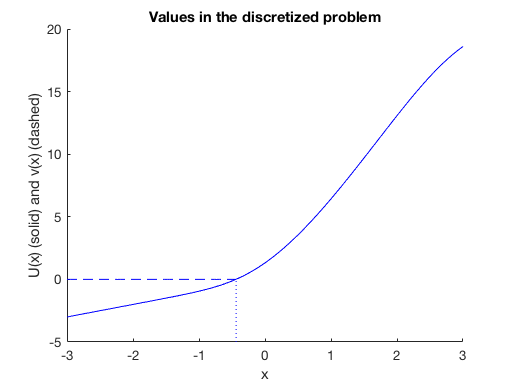

In [3]:
v=0; vOld=1;
while max(max(abs(v-vOld)))>tol
    vOld = v;
    v = bellman(vOld);
end

capU = suppX'+rho*(capPi*v); 
exitThreshold = min(suppX(find(capU>0)))

hold on;
    title('Values in the discretized problem');
    xlabel('x');
    ylabel('U(x) (solid) and v(x) (dashed)');
    plot(suppX,v,'--b');
    plot(suppX,capU,'-b');
    plot([exitThreshold exitThreshold],[-5 0],':b');
hold off;

## The Continuous-State Problem

We now return to the original problem. In that problem, ${\cal X}=\mathbb{R}$ is not bounded. So, to ensure that $v$ is bounded, we specify $u(x)=\min\{x,\check{u}\}$, with $0<\check{u}<\infty$ (we do not have to bound $u$ from below for this, because the outside option of zero bounds $v$ from below). Provided that $\check{u}$ is no smaller than the upper bound of the support of $X$ in the discretized problem, the two problems are close in the sense that their utilities coincide on the discretization grid. 

### Bellman Operator

We will focus on approximating $U^*=U-u$, because it is bounded unlike $U$ and smoother than $v$ (so that it is easier to approximate with off-the-shelf methods than $U$ or $v$), and then compute $U=U^*+u$ and $v=\max\{U,0\}$. Note that $U^*$ is the fixed point of the operator $\Psi^*:{\cal U}\rightarrow{\cal U}$ such that $\Psi^*(U^*)(x)=\rho\mathbb{E}[\max\{U^*(X')+u(X'),0\}\;|\;X=x]$, with $({\cal U},m)$ the space of bounded functions with supremum metric $m$. It easy to verify that, because $u$ is nondecreasing, $\Psi^*:{\cal U}_+\rightarrow{\cal U}_+$, with ${\cal U}_+$ the set of nonnegative and nondecreasing functions in ${\cal U}$. Because $({\cal U}_+,m)$ is complete, this implies that $\Psi^*$ has a unique fixed point in ${\cal U}_+$. Because ${\cal U}_+\subset{\cal U}$, this implies that $U^*\in{\cal U}_+$. Moreover, as $\Psi^*$ maps nondecreasing functions into strictly increasing functions, $U^*$ is necessarily *strictly* increasing. In turn, this implies that $U$ is strictly increasing and that it is optimal to terminate the relationship if and only if $X$ falls below a threshold $\underline x$.

### Fitted Value Iteration

We will solve the decision problem by fitted value iteration, which generates a sequence $\nu_0,\nu_1,\nu_2,\ldots$ of candidate values of $U^*$. Because ${\cal X}=\mathbb{R}$ is infinite (in fact, uncountable), we generally cannot calculate $\Psi^*(\nu)(x)$ exactly for all $x\in{\cal X}$. Therefore, in each iteration $n$, we only compute $\Psi^*(\nu_{n-1})(x)$ for $x$ in a set ${\cal X}^*\subset{\cal X}$ with $K+1<\infty$ elements $-\infty<x_1^*<\cdots<x_K^*<x_{K+1}^*<\infty$, with $x_1^*$ sufficiently small and $x_{K+1}^*>0$ (so that $\nu_n(x_1^*)+u(x_1^*)<0$ and $\nu_n(x_{K+1}^*)+u(x_{K+1}^*)>0$ for all $n$). Subsequently, we set $\nu_n=\Xi\circ\Psi^*(\nu_{n-1})$, with $\Xi$ the operator that maps a function $\nu$ into the linear spline that interpolates $\nu$ at knots ${\cal X}^*$ (with constant extrapolation to $(-\infty,x_1^*)$ and $(x_{K+1}^*,\infty)$):
$$
\Xi(\nu)=\left\{\begin{array}{ll}
    \nu(x^*_1)&\text{if }x\leq x^*_1;\\
    \nu(x^*_k)+\frac{x-x^*_k}{x^*_{k+1}-x^*_k}\left[\nu(x^*_{k+1})-\nu(x^*_k)\right]&\text{if }x^*_k<x\leq x^*_{k+1},~k=1,\ldots,K;\text{ and}\\
    \nu(x^*_{K+1})&\text{if }x>x^*_{K+1}.
\end{array}\right.
$$
Note that $\Xi(\nu)$ only requires the values of $\nu$ on the finite set ${\cal X}^*$, so that it can be stored as a finite vector on a computer. Moreover, it preserves monotonicity: If $\nu$ is increasing, then so is $\Xi(\nu)$. Finally, it is *nonexpanding*: $m(\Xi(\nu),\Xi(\nu'))\leq m(\nu,\nu')$, which ensures that fitted value iteration converges monotonically to the unique $U^*$ (Stachurski, 2009, Section 10.2.3).

Practically, the fitted value iteration procedure proceeds as follows. 
1. Set $\nu_0$ equal to some linear spline in ${\cal U}_+$ with knots ${\cal X}^*$, such as simply $\nu_0=0$. 
2. Set $n=1$. 
3. Note that $\nu_{n-1}\in{\cal U}_+$ is a linear spline that interpolates $\{\nu_{n-1}(x); x\in{\cal X}^*\}$. Set $\underline x_n$ such that $\nu_{n-1}(\underline x_n)+u(\underline x_n)=0$ (recall that we have picked $x^*_1$ and $x^*_{K+1}$ such that $x^*_1<\underline x_n<x^*_{K+1}$). Let $k_n\in\{1,\ldots,K\}$ be such that $x^*_{k_n}<\underline x_n<x^*_{k_n+1}$. Then, evaluate
$$
\Psi^*(\nu_{n-1})(x) = \rho\mathbb{E}[\max\{\nu_{n-1}(X')+u(X'),0\}\;|\;X=x]
$$
at all $x\in{\cal X}^*$ and set $\nu_n=\Xi\circ\Psi^*(\nu_{n-1})$ (to this end, we can simply store $\{\nu_{n}(x); x\in{\cal X}^*\}$).
4. If $m(\nu_{n-1},\nu_n)$ exceeds some positive tolerance, increase $n$ by one and return to 2.

The expectation in step 3 satisfies
$$
\begin{aligned}
\Psi^*(\nu_{n-1})(x) &= \rho\mathbb{E}[\max\{\nu_{n-1}(X')+u(X'),0\}\;|\;X=x]\\
                     &= \rho\int_{\underline x_n}^\infty\left[\nu_{n-1}(x')+u(x')\right]\frac{1}{\sigma}\phi\left(\frac{x'-x-\mu}{\sigma}\right)dx'\\
                     &= \rho\int_{\underline x_n}^\infty\nu_{n-1}(x')\frac{1}{\sigma}\phi\left(\frac{x'-x-\mu}{\sigma}\right)dx'+\rho\int_{\underline x_n}^\infty u(x')\frac{1}{\sigma}\phi\left(\frac{x'-x-\mu}{\sigma}\right)dx'.
\end{aligned}
$$
The first integral is
$$
\begin{aligned}
\int_{\underline x_n}^\infty\nu_{n-1}(x')\frac{1}{\sigma}\phi\left(\frac{x'-x-\mu}{\sigma}\right)dx'
=&\int_{\underline x_n}^{x^*_{k_n+1}} \left[ \nu_{n-1}(x^*_{k_n})+\frac{x'-x^*_{k_n}}{x^*_{{k_n}+1}-x^*_{k_n}}\left[\nu_{n-1}(x^*_{{k_n}+1})-\nu_{n-1}(x^*_{k_n})\right]\right]\frac{1}{\sigma}\phi\left(\frac{x'-x-\mu}{\sigma}\right)dx'\\
&+\sum_{k=k_n+1}^K\left[\Phi\left(\frac{{x^*_{k+1}}-x-\mu}{\sigma}\right)-\Phi\left(\frac{{x^*_k}-x-\mu}{\sigma}\right)\right]\nu_{n-1}(x^*_k)\\
&+\sum_{k=k_n+1}^K\int_{x^*_k}^{x^*_{k+1}}\frac{x'-x^*_k}{x^*_{k+1}-x^*_k}\frac{1}{\sigma}\phi\left(\frac{x'-x-\mu}{\sigma}\right)dx' \left[\nu_{n-1}(x^*_{k+1})-\nu_{n-1}(x^*_k)\right]\\
&+\left[1-\Phi\left(\frac{x^*_{K+1}-x-\mu}{\sigma}\right)\right]\nu_{n-1}(x^*_{K+1})
\end{aligned}
$$
and the second integral equals
$$
\begin{aligned}
\int_{\underline x_n}^\infty u(x')\frac{1}{\sigma}\phi\left(\frac{x'-x-\mu}{\sigma}\right)dx'
&=\int_{\underline x_n}^{\check u}x'\frac{1}{\sigma}\phi\left(\frac{x'-x-\mu}{\sigma}\right)dx'+\left[1-\Phi\left(\frac{\check u-x-\mu}{\sigma}\right)\right]\check u.
\end{aligned}
$$
Note that all integrals in the resulting expression for $\Psi^*(\nu_{n-1})(x)$ can be computed in advance, before starting the fitted value iterations, except for the two integrals that have $\underline x_n$ as a limit. The latter need to be computed in iteration $n$.  

We first set the numerical design, specify the new model components, and compute the integrals that do not have $\underline x_n$ as a limit.  

In [4]:
endX = [-4 4]; % first and last knot of interpolating spline
nX = 301; % number of equidistant knots spline
knotsX = endX(1):(endX(2)-endX(1))/(nX-1):endX(2); % {\cal} X}^* 

ucheck = 3; 
u=@(x)(ucheck+(x-ucheck).*(x<ucheck)); % Capped utility
uX = u(knotsX);
phi = @(x)normpdf((x-knotsX-mu)/sigma)/sigma;
capPhi = @(x) normcdf((x-knotsX-mu)/sigma);

int_1_b = nan(nX-1,nX);
for k=1:(nX-1)
    int_1_b(k,:) = capPhi(knotsX(k+1))-capPhi(knotsX(k));
end

int_1_c = nan(nX-1, nX);
for k=1:(nX-1)
    int_1_c_func = @(x) phi(x)*(x - knotsX(k)) / (knotsX(k+1) - knotsX(k));
    int_1_c(k,:) = integral(int_1_c_func,knotsX(k),knotsX(k+1),'ArrayValued',true);
end

int_1_d = 1-capPhi(knotsX(end)) ;
int_2_b = (1-capPhi(ucheck))*ucheck ;

We compute the remaining integrals repeatedly until convergence of the fitted value iteration procedure.

In [5]:
Ustar=zeros(1,nX); UstarOld=Ustar+1;
while max(max(abs(Ustar-UstarOld)))>tol
    UstarOld = Ustar;
    
    % find x_n
    ind_x_kn = find(u(knotsX) + UstarOld<0, 1, 'last'); 
    x_kn = knotsX(ind_x_kn);
    x_knplus1 = knotsX(ind_x_kn+1);
    U_kn = u(knotsX(ind_x_kn)) + UstarOld(ind_x_kn);
    U_knplus1 = u(knotsX(ind_x_kn+1)) + UstarOld(ind_x_kn+1);
    slope = (U_knplus1 - U_kn) / (x_knplus1 - x_kn);
    xn = x_kn - U_kn/slope;
    
    % compute remaining terms on r.h.s.
    int_1_a_func = @(x) (UstarOld(ind_x_kn) + (UstarOld(ind_x_kn+1)-UstarOld(ind_x_kn))...
                                    *(x - x_kn) / (x_knplus1 - x_kn)) * phi(x);
    int_1_a = integral(int_1_a_func,xn,x_knplus1,'ArrayValued',true);

    int_1_b_Ustar = int_1_b.*repmat(UstarOld(1:end-1)',1,nX) ;
    int_1_b_summed = sum(int_1_b_Ustar((ind_x_kn+1):end,:),1);
    
    int_1_c_Ustar = int_1_c.*(repmat(UstarOld(2:end)'-UstarOld(1:end-1)',1,nX));
    int_1_c_summed = sum(int_1_c_Ustar((ind_x_kn+1):end,:),1);
    
    int_2_a_func = @(x) x*phi(x);
    int_2_a = integral(int_2_a_func,xn,ucheck,'ArrayValued',true);
    
    % construct implied new value of Ustar
    Ustar = rho*(int_1_a + int_1_b_summed + int_1_c_summed + int_1_d*UstarOld(end) ...
                    + int_2_a + int_2_b);
end

Finally, we plot the resulting fitted value functions for the original (continuous) problem (red) together with the value functions for the discretized problem (blue).

EXIT THRESHOLDS
original     discretized problem
   -0.4463   -0.4380



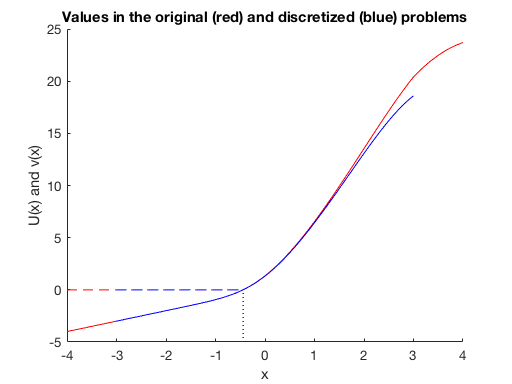

In [6]:
vCont = max([uX+Ustar;zeros(1,nX)]);
disp('EXIT THRESHOLDS');
disp('original     discretized problem');
disp([xn exitThreshold]);
hold on;
    xlabel('x');
    ylabel('U(x) and v(x)');
    title('Values in the original (red) and discretized (blue) problems');
    plot(knotsX,uX+Ustar,'-r');
    plot(knotsX,vCont,'--r');
    plot([xn xn],[-5 0],':r');
    plot(suppX,capU,'-b');
    plot(suppX,v,'--b');
    plot([exitThreshold exitThreshold],[-5 0],':b');
hold off;

## References

Stachurski, John (2009). Economic Dynamics: Theory and Computation. MIT Press, Cambridge, MA.